# Nonlinear Regression with ParmEst

In [1]:
import sys

# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import (
    TCLabExperiment,
    create_model,
    extract_results,
    extract_plot_results,
    results_summary,
)

# set default number of states in the TCLab model
number_tclab_states = 2

## Load and explore experimental data

In [2]:
import pandas as pd

if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_sine_test.csv"
else:
    file = '../data/tclab_sine_test.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,24.45,24.13,50.0,0.0
1,1.00,24.45,24.13,55.0,0.0
2,2.01,24.45,24.13,60.0,0.0
3,3.01,24.45,24.13,65.0,0.0
4,4.01,24.77,23.81,70.0,0.0


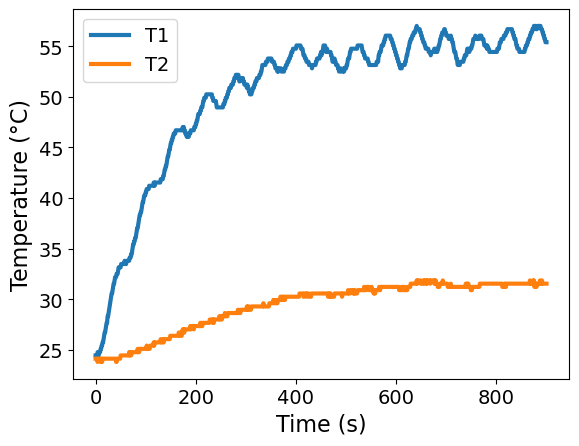

In [3]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')

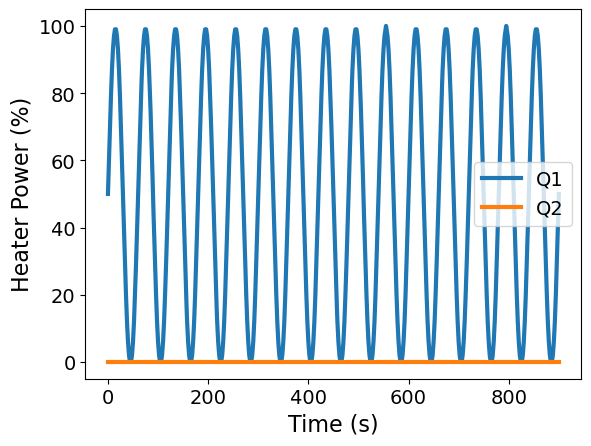

In [4]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

## Store in Custom Data Class 

In the file `tclab_pyomo.py`, we defined a `dataclass` for convenience. It is essentially a light weight container to store experimental data.

In [5]:
tc_data = TCLabExperiment(
    name="Sine Wave Test for Heater 1",
    time=df['Time'].values,
    T1=df['T1'].values,
    u1=df['Q1'].values,
    P1=200,
    TS1_data=None,
    T2=df['T2'].values,
    u2=df['Q2'].values,
    P2=200,
    TS2_data=None,
    Tamb=df['T1'].values[0],
)

In [6]:
tc_data.to_data_frame().head()

,time,T1,u1,P1,TS1_data,T2,u2,P2,TS2_data,Tamb
0,0.00,24.45,50.0,200,None,24.13,0.0,200,None,24.45
1,1.00,24.45,55.0,200,None,24.13,0.0,200,None,24.45
2,2.01,24.45,60.0,200,None,24.13,0.0,200,None,24.45
3,3.01,24.45,65.0,200,None,24.13,0.0,200,None,24.45
4,4.01,24.77,70.0,200,None,23.81,0.0,200,None,24.45


## Parameter Estimation with ParmEst

We seek to solve minimize of weighted sum of residuals squared:

$$
\begin{align*}
\min_{C_p^H, C_p^S, U_a, U_b} \sum_{i \in \mathcal{T}} \left(T_{S}(t_i) - \bar{T}_{S,i} \right)^2 + w \left(T_{H}(t_i) - \bar{T}_{S,i} \right)^2
\end{align*}
$$

subject to constraints

$$
\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_c (T_S - T_H) + \alpha P u(t)\\
C_p^S \frac{dT_S}{dt} & = - U_b (T_S - T_H)  \\
\\
\text{control input data}\qquad u(t_i) & = \bar{u}_{i}, \forall i \in \mathcal{T}
\\
\text{initial condition}\qquad T_H(t_0) & = T_{amb} \\
\text{initial condition}\qquad T_S(t_0) & = T_{amb}
\end{align*}
$$

Here $\bar{T}_{S,i}$ and $\bar{u}_i$ are the measured sensor temperatures and control signals, respectives, at times $i \in \mathcal{T}$. $w$ is a small weight that helps regularize the solution by preventing the model predictions $T_H$ from deviating too much from the measured temperatures.


In the `tclab_pyomo.py` model, we defined several helper functions:
* `create_model` generates a Pyomo model that is initialized using a numeric integrator. The `mode` option determines which objective function to include.
* `extract_results` takes a Pyomo model and returns the results stored in an instance of the `TCLabExperiment` dataclass.
* `extract_plot_results` takes experimental data (stored in a `TCLabExperiment` instance) and a Pyomo model. The function then generates plots showing the data and model predictions.
* `results_summary` summarizes the Pyomo.DoE results. We'll use this later in the workshop.

`parmest` assumes the regression objective is specified in a specific way. Here is a code exercpt from `tclab_pyomo.py`:

```
m.FirstStageCost = Expression(expr=0)
m.SecondStageCost = Expression(expr=sum((m.Ts1[t] - m.Ts1_measure[t])**2 
    + obj_weight_estimate*(m.Th1[t] - m.Ts1_measure[t])**2 for t in m.t))
m.Total_Cost_Objective = Objective(expr=m.FirstStageCost 
    + m.SecondStageCost, sense=minimize)
```

In [7]:
import pyomo.contrib.parmest.parmest as parmest

# define the parameter names as a list
if number_tclab_states == 2:
    theta_names = ['Ua', 'Ub', 'inv_CpH', 'inv_CpS']
else:
    theta_names = ['Ua', 'Ub', 'Uc', 'inv_CpH', 'inv_CpS']

parmest_create_model = lambda data: create_model(
    data=data, mode='parmest', number_of_states=number_tclab_states
)

# Create a parameter estimation object
pest = parmest.Estimator(
    parmest_create_model,
    data=[
        tc_data.to_data_frame()
    ],  # Needs to be a list of dataframes, otherwise parmest threats each row as a separate model
    theta_names=theta_names,
    tee=True,
)

obj, theta = pest.theta_est()

(model_function, data, theta_names). This interface will be removed in a
future release, please update to the new parmest interface using experiment
lists.  (deprecated in 6.7.2) (called from
/Users/adowling/opt/anaconda3/envs/summer2024/lib/python3.10/functools.py:926)
Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.13.2, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    15301
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     8103

Total number of variables............................:     3606
     

During Summer 2024, we are creating a new modeling interface for `parmest` and `Pyomo.DoE`. This notebook currently uses the legacy `parmest` interface, hence the depreciation warnings above. Once the revisions are complete, we will update this workshop website.

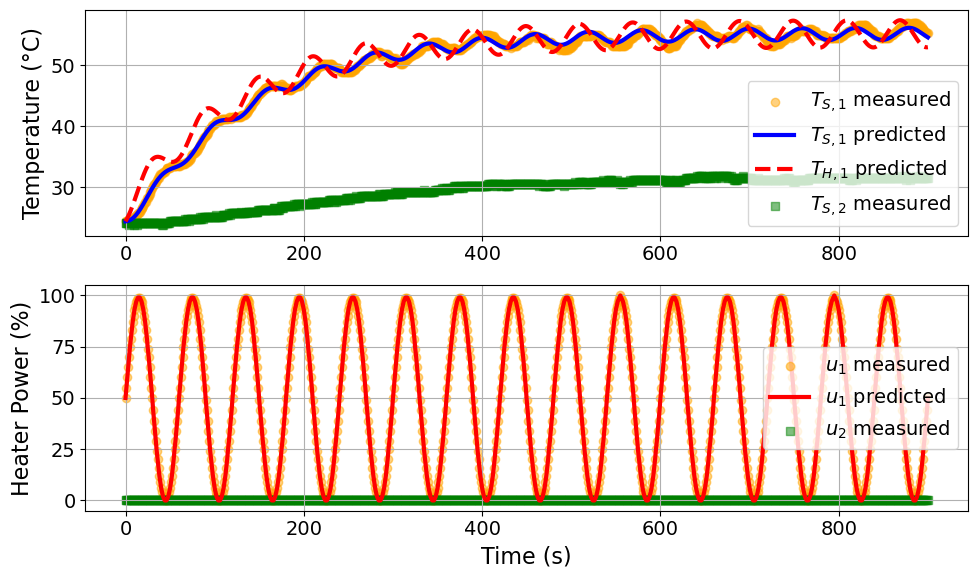

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
 


In [8]:
parmest_regression_results = extract_plot_results(
    tc_data, pest.pest_deprecated.parmest_model
)

Let's see how to access the regression results:

In [9]:
theta_values = theta.to_dict()
print("Estimated parameters:\n", theta_values)

Estimated parameters:
 {'Ua': 0.05147278733764144, 'Ub': 0.0005342082803591557, 'inv_CpH': 0.1462287940317429, 'inv_CpS': 99.99999854623738}
